# Analysis of all DJA/SE++ catalogs combined

This notebook creates scientific plots from the merged catalogs from SourceXtractor++ (Sersic and Bulge+Disk models) and from the DJA (aperture photometry and photo-z).

In [1]:
import os
import glob
import re
import boto3
s3 = boto3.client('s3')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
from astropy.table import Table, vstack
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.visualization import ImageNormalize, ZScaleInterval, MinMaxInterval, LogStretch
from astropy.coordinates import SkyCoord
import astropy.units as u
import dja_sepp

plt.rcParams['xtick.labelsize']='large'
plt.rcParams['ytick.labelsize']='large'
plt.rcParams['axes.labelsize']='x-large'
plt.rcParams['legend.fontsize']='large'
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
# %matplotlib ipympl

In [2]:
home = "/home/aurelien/DAWN/DJA-SEpp"

#### Open catalogs (field by field)

In [3]:
fields = ['ceers-full-grizli-v7.2', 
          'gdn-grizli-v7.3', 'gds-grizli-v7.2', 
          'primer-uds-north-grizli-v7.2', 'primer-uds-south-grizli-v7.2',
          'primer-cosmos-west-grizli-v7.0', 'primer-cosmos-east-grizli-v7.0']

TAB_DJA = []
TAB_SERSIC = []
TAB_BD = []
for field in fields:
    print(field)
    with fits.open(f"{home}/fields/{field}/catalog/{field}_morpho-phot.fits.gz") as hdul:
        tab_dja = Table(hdul[1].data)
        tab_sersic = Table(hdul[2].data)
        tab_BD = Table(hdul[3].data)
        good = (tab_sersic['flag']==2) & (tab_BD['flag']==2)
        good_dja = tab_dja[good]
        good_sersic = tab_sersic[good]
        good_BD = tab_BD[good]
        good_dja.add_column(field, 0, 'field')
        TAB_DJA.append(good_dja)
        TAB_SERSIC.append(good_sersic)
        TAB_BD.append(good_BD)
del tab_dja
del tab_sersic
del tab_BD

ceers-full-grizli-v7.2
gdn-grizli-v7.3
gds-grizli-v7.2
primer-uds-north-grizli-v7.2
primer-uds-south-grizli-v7.2
primer-cosmos-west-grizli-v7.0
primer-cosmos-east-grizli-v7.0


In [4]:
good_dja = vstack(TAB_DJA)
good_sersic = vstack(TAB_SERSIC)
good_BD = vstack(TAB_BD)
del TAB_DJA
del TAB_SERSIC
del TAB_BD

In [5]:
# Save complete good table
to_remove = np.array(good_dja.colnames)[[re.fullmatch("f\d+((?!flux).)*", col) is not None for col in good_dja.colnames]]
good_dja.remove_columns(to_remove)
print("HDU DJA")
hdu_dja = fits.BinTableHDU(good_dja)
del good_dja
print("HDU Sérsic")
hdu_sersic = fits.BinTableHDU(good_sersic)
del good_sersic
print("HDU B+D")
hdu_BD = fits.BinTableHDU(good_BD)
del good_BD
print("HDUL")
hdul = fits.HDUList([fits.PrimaryHDU(), hdu_dja, hdu_sersic, hdu_BD])
hdul.writeto(f"{home}/fields/full-good_morpho-phot.fits.gz", overwrite=True) # Compressed
del hdul

HDU DJA


#### Open catalog (full)

In [3]:
with fits.open(f"{home}/fields/full-good_morpho-phot.fits.gz") as hdul:
    good_dja = Table(hdul[1].data)
    good_sersic = Table(hdul[2].data)
    good_BD = Table(hdul[3].data)

## Morphology

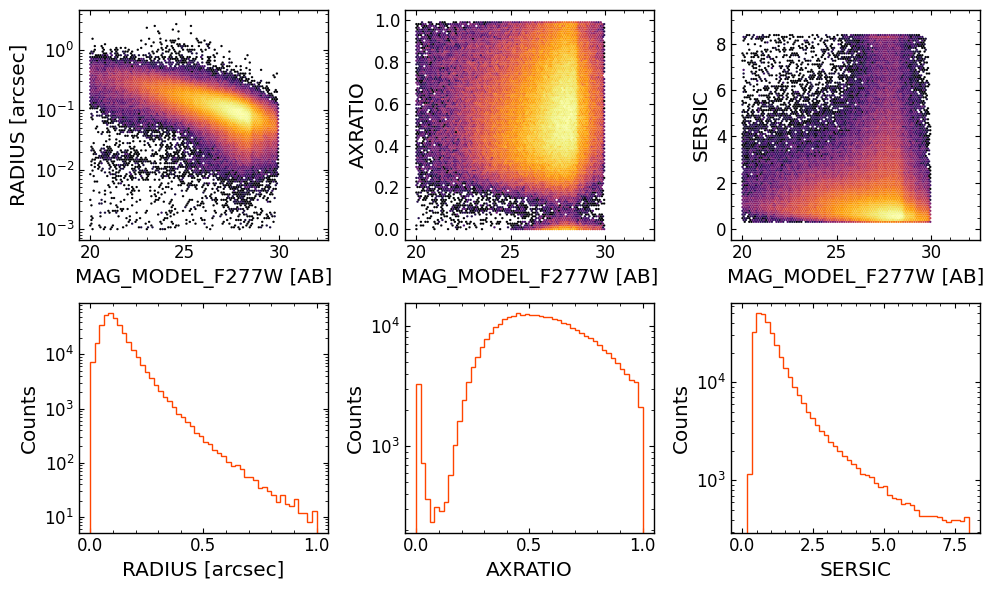

In [7]:
# sersic_rg4

plot_sersic = good_sersic

filter = 'f277w'
fig, axs = plt.subplots(2,3, figsize=(10,6))

axs[0,0].hexbin(plot_sersic[f'MAG_MODEL_{filter.upper()}'], plot_sersic['RADIUS']*3600, mincnt=1, gridsize=100, cmap='inferno', bins='log', yscale='log', extent=(20,32,-3,0.5), lw=0.01)
axs[0,0].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,0].set_ylabel("RADIUS [arcsec]")

axs[0,1].hexbin(plot_sersic[f'MAG_MODEL_{filter.upper()}'], plot_sersic['AXRATIO'], mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(20,32,0,1), lw=0.01)
axs[0,1].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,1].set_ylabel("AXRATIO")

axs[0,2].hexbin(plot_sersic[f'MAG_MODEL_{filter.upper()}'], plot_sersic['SERSIC'], mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(20,32,0,9), lw=0.01)
axs[0,2].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,2].set_ylabel("SERSIC")

axs[1,0].hist(plot_sersic['RADIUS']*3600, bins=50, range=(0,1), histtype='step', log=True, color='orangered')
axs[1,0].set_xlabel("RADIUS [arcsec]")
axs[1,0].set_ylabel("Counts")

axs[1,1].hist(plot_sersic['AXRATIO'], bins=50, range=(0,1), histtype='step', log=True, color='orangered')
axs[1,1].set_xlabel("AXRATIO")
axs[1,1].set_ylabel("Counts")

axs[1,2].hist(plot_sersic['SERSIC'], bins=50, range=(0,8), histtype='step', log=True, color='orangered')
axs[1,2].set_xlabel("SERSIC")
axs[1,2].set_ylabel("Counts")

fig.tight_layout()
fig.savefig(f"{home}/fields/sersic_rg4_morphology.pdf", bbox_inches='tight')
fig.savefig(f"{home}/fields/sersic_rg4_morphology.png", bbox_inches='tight', dpi=200)
plt.show()

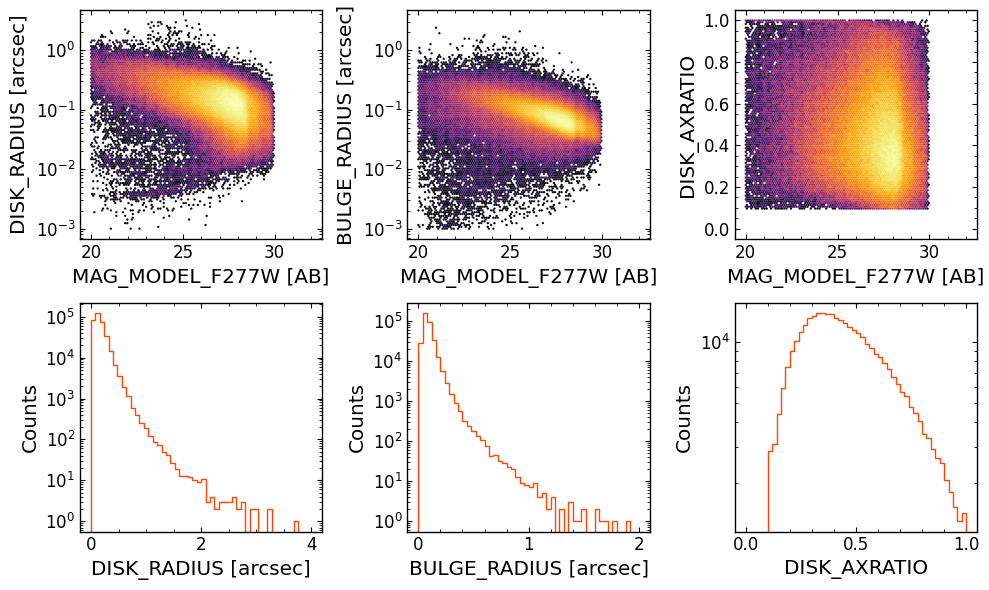

In [8]:
# B+D

plot_BD = good_BD

filter = 'f277w'
fig, axs = plt.subplots(2,3, figsize=(10,6))

axs[0,0].hexbin(plot_BD[f'MAG_MODEL_{filter.upper()}'], plot_BD['DISK_RADIUS_deg']*3600, mincnt=1, gridsize=100, cmap='inferno', bins='log', yscale='log', extent=(20,32,-3,0.5), lw=0.01)
axs[0,0].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,0].set_ylabel("DISK_RADIUS [arcsec]")

axs[0,1].hexbin(plot_BD[f'MAG_MODEL_{filter.upper()}'], plot_BD['BULGE_RADIUS_deg']*3600, mincnt=1, gridsize=100, cmap='inferno', bins='log', yscale='log', extent=(20,32,-3,0.5), lw=0.01)
axs[0,1].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,1].set_ylabel("BULGE_RADIUS [arcsec]")

axs[0,2].hexbin(plot_BD[f'MAG_MODEL_{filter.upper()}'], plot_BD['DISK_AXRATIO'], mincnt=1, gridsize=100, cmap='inferno', bins='log', extent=(20,32,0,1), lw=0.01)
axs[0,2].set_xlabel(f"MAG_MODEL_{filter.upper()} [AB]")
axs[0,2].set_ylabel("DISK_AXRATIO")

axs[1,0].hist(plot_BD['DISK_RADIUS_deg']*3600, bins=50, range=(0,4), histtype='step', log=True, color='orangered')
axs[1,0].set_xlabel("DISK_RADIUS [arcsec]")
axs[1,0].set_ylabel("Counts")

axs[1,1].hist(plot_BD['BULGE_RADIUS_deg']*3600, bins=50, range=(0,2), histtype='step', log=True, color='orangered')
axs[1,1].set_xlabel("BULGE_RADIUS [arcsec]")
axs[1,1].set_ylabel("Counts")

axs[1,2].hist(plot_BD['DISK_AXRATIO'], bins=50, range=(0,1), histtype='step', log=True, color='orangered')
axs[1,2].set_xlabel("DISK_AXRATIO")
axs[1,2].set_ylabel("Counts")

fig.tight_layout()
fig.savefig(f"{home}/fields/B+D_morphology.pdf", bbox_inches='tight')
fig.savefig(f"{home}/fields/B+D_morphology.png", bbox_inches='tight', dpi=200)
plt.show()

## UVJ plots

In [4]:
snr_cond = (good_sersic['snrratio']>100) & (good_sersic['MAG_MODEL_F277W']<30)
mass_cond = good_dja['mass'] > np.power(10, 10)
print(len(good_dja[snr_cond & mass_cond]))

13501


/tmp/ipykernel_16952/3523982696.py:8: RuntimeWarning: invalid value encountered in log10
  uv = -2.5*np.log10(good_dja[cond]['restU']/good_dja[cond]['restV'])
/tmp/ipykernel_16952/3523982696.py:9: RuntimeWarning: invalid value encountered in log10
  vj = -2.5*np.log10(good_dja[cond]['restV']/good_dja[cond]['restJ'])
/tmp/ipykernel_16952/3523982696.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0,0,1,1))


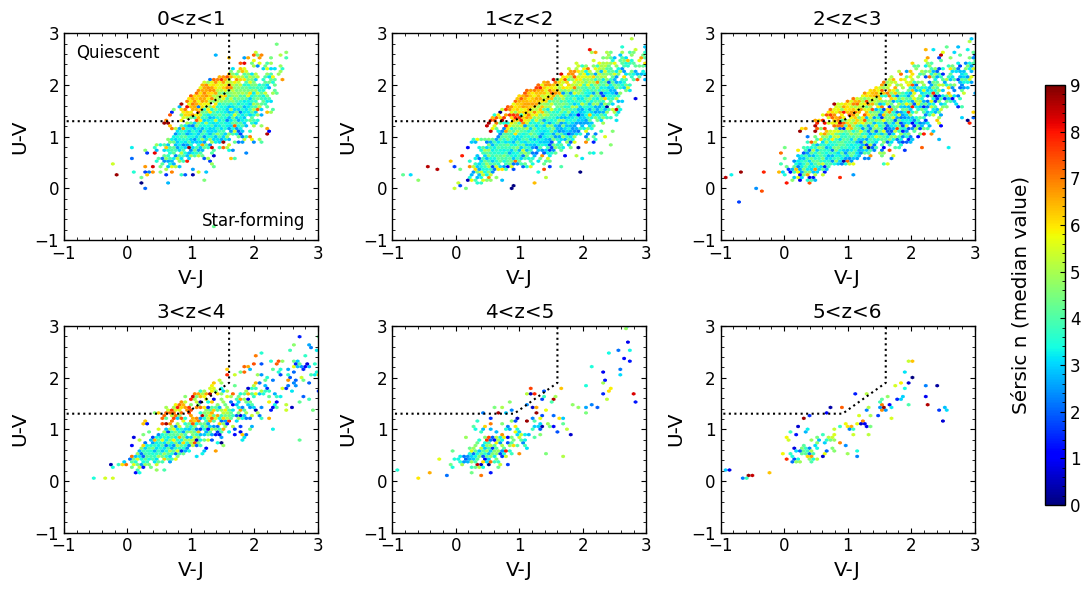

In [5]:
fig, axs = plt.subplots(2,3, figsize=(10,6))

for i in range(6):
    z = (i, i+1)
    ax = axs.flatten()[i]
    z_cond = (good_dja['z_phot']>z[0])&(good_dja['z_phot']<z[1])
    cond = snr_cond & mass_cond & z_cond
    uv = -2.5*np.log10(good_dja[cond]['restU']/good_dja[cond]['restV'])
    vj = -2.5*np.log10(good_dja[cond]['restV']/good_dja[cond]['restJ'])
    ax.plot([-2,0.92,1.6,1.6], [1.3,1.3,1.898,4], ls=':', c='k')
    ax.hexbin(x=vj, y=uv, C=good_sersic[cond]['SERSIC'], reduce_C_function=np.median,
              mincnt=1, gridsize=100, cmap='jet', bins='log', extent=(-2,4,-2,4), lw=0.01, vmax=9)
    ax.set_xlim(-1,3)
    ax.set_ylim(-1,3)
    ax.set_title(f"{z[0]}<z<{z[1]}")
    ax.set_xlabel("V-J")
    ax.set_ylabel("U-V")
    if i==0: ax.text(0.05, 0.95, "Quiescent", transform=ax.transAxes, ha='left', va='top', fontsize='large')
    if i==0: ax.text(0.95, 0.05, "Star-forming", transform=ax.transAxes, ha='right', va='bottom', fontsize='large')

cbar_ax = fig.add_axes([1.05, 0.15, 0.02, 0.7])
norm = mpl.colors.Normalize(vmin=0,vmax=9)
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('jet'), norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, ticks=np.linspace(0,9,10), cax=cbar_ax, label='Sérsic n (median value)')
cb.set_label("Sérsic n (median value)", labelpad=-50)

fig.tight_layout(rect=(0,0,1,1))
# fig.savefig(f"{home}/fields/UVJ-sersic.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/UVJ-sersic.png", bbox_inches='tight', dpi=200)
plt.show()

/tmp/ipykernel_11029/3062754709.py:8: RuntimeWarning: invalid value encountered in log10
  uv = -2.5*np.log10(good_dja[cond]['restU']/good_dja[cond]['restV'])
/tmp/ipykernel_11029/3062754709.py:9: RuntimeWarning: invalid value encountered in log10
  vj = -2.5*np.log10(good_dja[cond]['restV']/good_dja[cond]['restJ'])
/tmp/ipykernel_11029/3062754709.py:8: RuntimeWarning: invalid value encountered in log10
  uv = -2.5*np.log10(good_dja[cond]['restU']/good_dja[cond]['restV'])


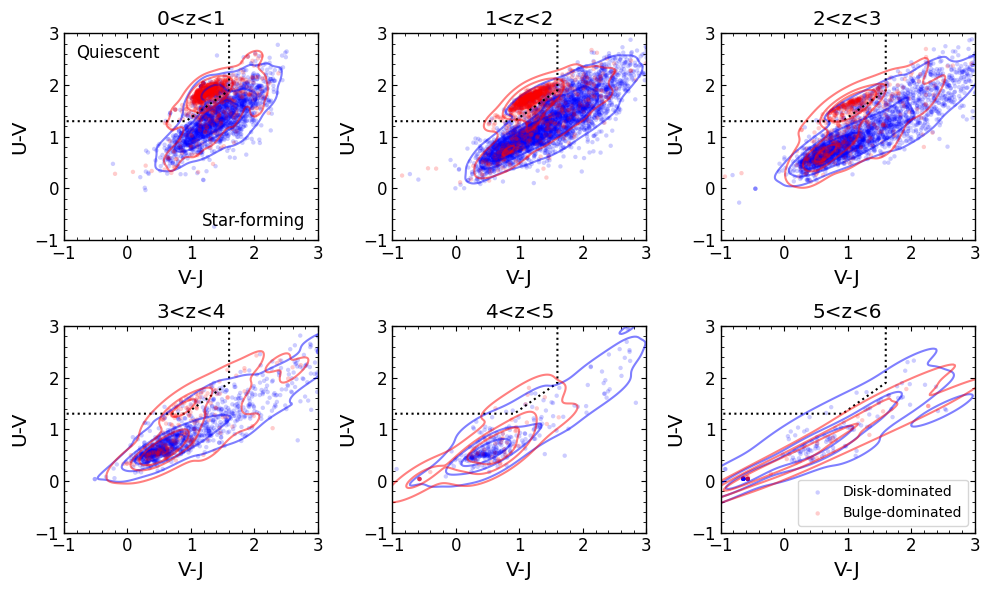

In [11]:
fig, axs = plt.subplots(2,3, figsize=(10,6))

for i in range(6):
    z = (i, i+1)
    ax = axs.flatten()[i]
    z_cond = (good_dja['z_phot']>z[0])&(good_dja['z_phot']<z[1])
    cond = snr_cond & mass_cond & z_cond
    uv = -2.5*np.log10(good_dja[cond]['restU']/good_dja[cond]['restV'])
    vj = -2.5*np.log10(good_dja[cond]['restV']/good_dja[cond]['restJ'])
    disk = (good_sersic[cond]['SERSIC']<4)&(good_BD[cond]['B/T_F200W']<0.4)
    bulge = (good_sersic[cond]['SERSIC']>1)&(good_BD[cond]['B/T_F200W']>0.5)
    ax.plot([-2,0.92,1.6,1.6], [1.3,1.3,1.898,4], ls=':', c='k')
    ax.scatter(vj[disk], uv[disk], c='b', alpha=0.2, s=10, ec='none', label="Disk-dominated")
    sns.kdeplot(x=vj[disk], y=uv[disk], ax=ax, levels=4, color='b', alpha=0.5)
    ax.scatter(vj[bulge], uv[bulge], c='r', alpha=0.2, s=10, ec='none', label="Bulge-dominated")
    sns.kdeplot(x=vj[bulge], y=uv[bulge], ax=ax, levels=4, color='r', alpha=0.5)
    ax.set_xlim(-1,3)
    ax.set_ylim(-1,3)
    ax.set_title(f"{z[0]}<z<{z[1]}")
    ax.set_xlabel("V-J")
    ax.set_ylabel("U-V")
    if i==0: ax.text(0.05, 0.95, "Quiescent", transform=ax.transAxes, ha='left', va='top', fontsize='large')
    if i==0: ax.text(0.95, 0.05, "Star-forming", transform=ax.transAxes, ha='right', va='bottom', fontsize='large')

axs.flatten()[-1].legend(loc='lower right', fontsize='medium')

fig.tight_layout()
# fig.savefig(f"{home}/fields/UVJ-disk-bulge.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/UVJ-disk-bulge.png", bbox_inches='tight', dpi=200)
plt.show()

/tmp/ipykernel_16952/869957926.py:14: RuntimeWarning: invalid value encountered in log10
  uv = -2.5*np.log10(good_dja[cond]['restU']/good_dja[cond]['restV'])
/tmp/ipykernel_16952/869957926.py:15: RuntimeWarning: invalid value encountered in log10
  vj = -2.5*np.log10(good_dja[cond]['restV']/good_dja[cond]['restJ'])
/tmp/ipykernel_16952/869957926.py:14: RuntimeWarning: invalid value encountered in log10
  uv = -2.5*np.log10(good_dja[cond]['restU']/good_dja[cond]['restV'])
/tmp/ipykernel_16952/869957926.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=(0,0,1,1))


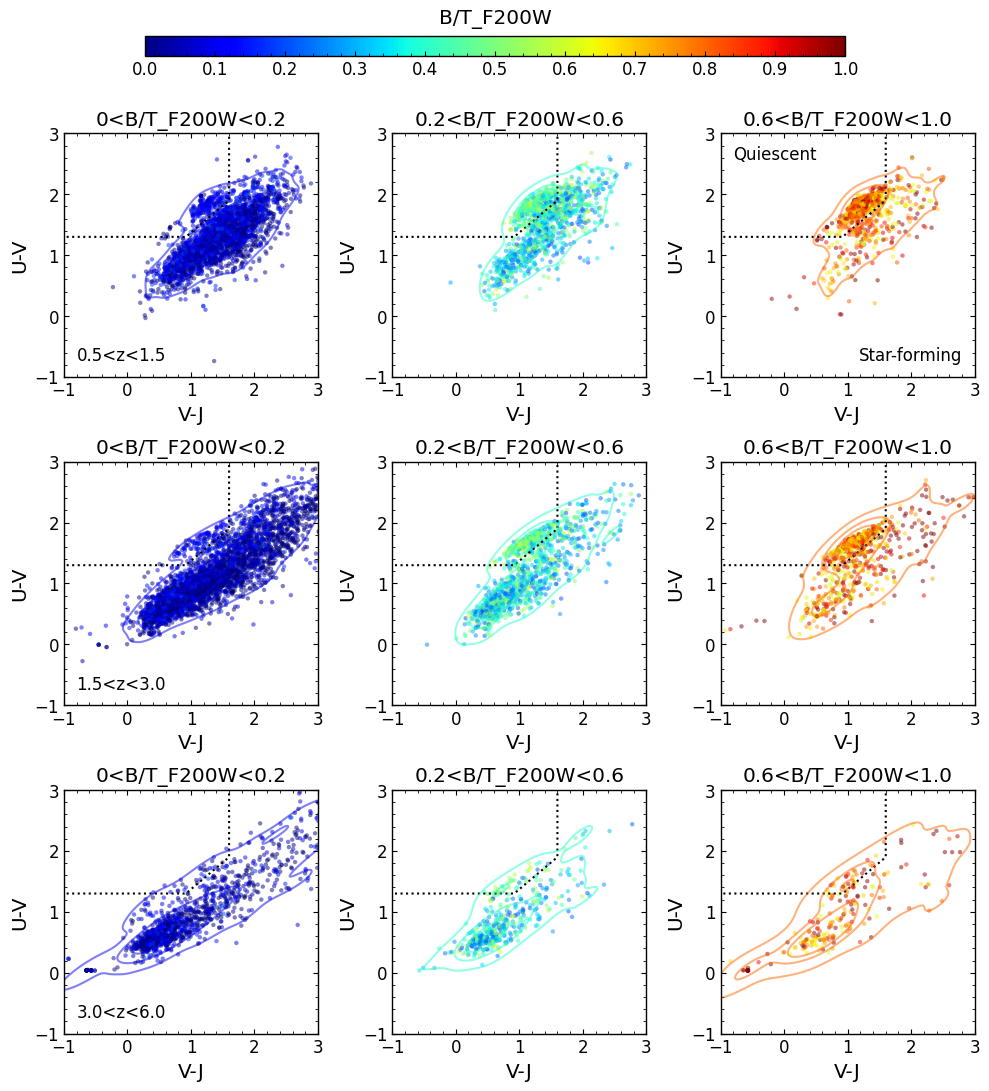

In [6]:
fig, axs = plt.subplots(3,3, figsize=(10,10))

Z = [(0.5,1.5),(1.5,3),(3,6)]
BT = [(0,0.2), (0.2,0.6), (0.6,1.0)]

for i in range(3):
    z = Z[i]
    z_cond = (good_dja['z_phot']>z[0])&(good_dja['z_phot']<z[1])
    for j in range(3):
        ax = axs[i,j]
        bt = BT[j]
        BT_cond = (good_BD['B/T_F200W']>bt[0])&(good_BD['B/T_F200W']<bt[1])
        cond = snr_cond & mass_cond & z_cond & BT_cond
        uv = -2.5*np.log10(good_dja[cond]['restU']/good_dja[cond]['restV'])
        vj = -2.5*np.log10(good_dja[cond]['restV']/good_dja[cond]['restJ'])
        ax.plot([-2,0.92,1.6,1.6], [1.3,1.3,1.898,4], ls=':', c='k')
        ax.scatter(vj, uv, c=good_BD[cond]['B/T_F200W'], alpha=0.5, s=10, ec='none', vmin=0, vmax=1, cmap='jet')
        sns.kdeplot(x=vj, y=uv, ax=ax, levels=4, color=mpl.colormaps.get_cmap('jet')(0.5*(bt[0]+bt[1])), alpha=0.5)
        ax.set_xlim(-1,3)
        ax.set_ylim(-1,3)
        ax.set_title(f"{bt[0]}<B/T_F200W<{bt[1]}")
        ax.set_xlabel("V-J")
        ax.set_ylabel("U-V")
        if j==0: ax.text(0.05, 0.05, f"{z[0]:.1f}<z<{z[1]:.1f}", transform=ax.transAxes, ha='left', va='bottom', fontsize='large')
        if (i==0)&(j==2): ax.text(0.05, 0.95, "Quiescent", transform=ax.transAxes, ha='left', va='top', fontsize='large')
        if (i==0)&(j==2): ax.text(0.95, 0.05, "Star-forming", transform=ax.transAxes, ha='right', va='bottom', fontsize='large')

cbar_ax = fig.add_axes([0.15, 1.04, 0.7, 0.02])
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('jet'), norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, orientation='horizontal', ticks=np.linspace(0,1,11), cax=cbar_ax)
cb.set_label("B/T_F200W", labelpad=-50)

fig.tight_layout(rect=(0,0,1,1))
# fig.savefig(f"{home}/fields/UVJ-BT.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/UVJ-BT.png", bbox_inches='tight', dpi=200)
plt.show()

## Size evolution

https://arxiv.org/pdf/2309.04377

In [97]:
# Selection
snr_cond = (good_sersic['snrratio']>100) & (good_sersic['MAG_MODEL_F277W']<28)
mass_cond = good_dja['mass'] > np.power(10, 10)
rad_cond = good_sersic['RADIUS']>2e-6

cond = snr_cond & mass_cond & rad_cond
print(len(good_dja[cond]))

13363


In [98]:
z = good_dja[cond]['z_phot']

z_bins = [0,1,2,3,4,6,8]

In [99]:
def scatter_bin(x, y, x_bins, color, ax, label=None, scatter=True, offset=0):
    x_center = 0.5*(x_bins+np.roll(x_bins, -1))[:-1]
    sigma = np.array([sigma_clipped_stats(y[(x>=x_bins[i])&(x<x_bins[i+1])]) for i in range(len(x_bins)-1)])
    if scatter: ax.scatter(x, y, c=color, s=5, alpha=0.2)
    ax.errorbar(x_center+offset, sigma[:,1], yerr=sigma[:,2], color=color, mec='k', capsize=5, ms=5, marker='D', label=label)

/home/aurelien/miniforge3/envs/dawn/lib/python3.9/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


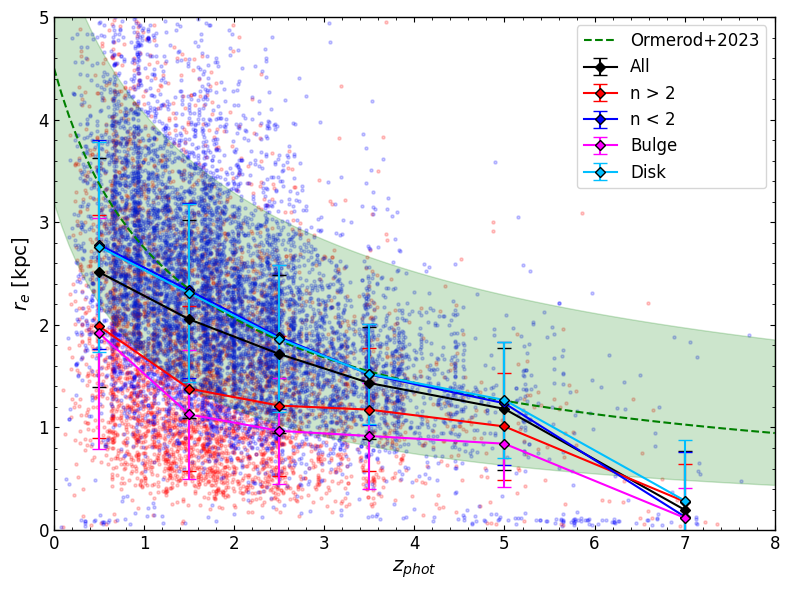

In [100]:
radius = (cosmo.kpc_proper_per_arcmin(good_dja['z_phot'])*good_sersic['RADIUS']*u.deg)[cond].to(u.kpc).value

fig, ax = plt.subplots(1,1, figsize=(8,6))

disk = (good_sersic[cond]['SERSIC']<4)&(good_BD[cond]['B/T_F200W']<0.4)
bulge = (good_sersic[cond]['SERSIC']>1)&(good_BD[cond]['B/T_F200W']>0.5)

scatter_bin(z, radius, z_bins, color='k', ax=ax, scatter=False, label='All')
scatter_bin(z[good_sersic[cond]['SERSIC']>2], radius[good_sersic[cond]['SERSIC']>2], z_bins, color='r', ax=ax, label='n > 2', scatter=True)
scatter_bin(z[good_sersic[cond]['SERSIC']<2], radius[good_sersic[cond]['SERSIC']<2], z_bins, color='b', ax=ax, label='n < 2', scatter=True)
scatter_bin(z[bulge], radius[bulge], z_bins, color='magenta', ax=ax, label='Bulge', scatter=False)
scatter_bin(z[disk], radius[disk], z_bins, color='deepskyblue', ax=ax, label='Disk', scatter=False)

# Ormerod+2023
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)
ax.plot(z_lin, 4.5*np.power(1+z_lin, -0.71), ls='--', c='green', label='Ormerod+2023')
ax.fill_between(z_lin, (4.5+1.32)*np.power(1+z_lin, -0.71+0.19), (4.5-1.32)*np.power(1+z_lin, -0.71-0.19), color='g', alpha=0.2)

ax.set_xlabel(r"$z_{phot}$")
ax.set_ylabel(r"$r_e$ [kpc]")
ax.legend()

ax.set_xlim(z_bins[0], z_bins[-1])
ax.set_ylim(0,5)

fig.tight_layout()
# fig.savefig(f"{home}/fields/size-evolution.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/size-evolution.png", bbox_inches='tight', dpi=200)
plt.show()

/home/aurelien/miniforge3/envs/dawn/lib/python3.9/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aurelien/miniforge3/envs/dawn/lib/python3.9/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aurelien/miniforge3/envs/dawn/lib/python3.9/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/tmp/ipykernel_11029/2487441700.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


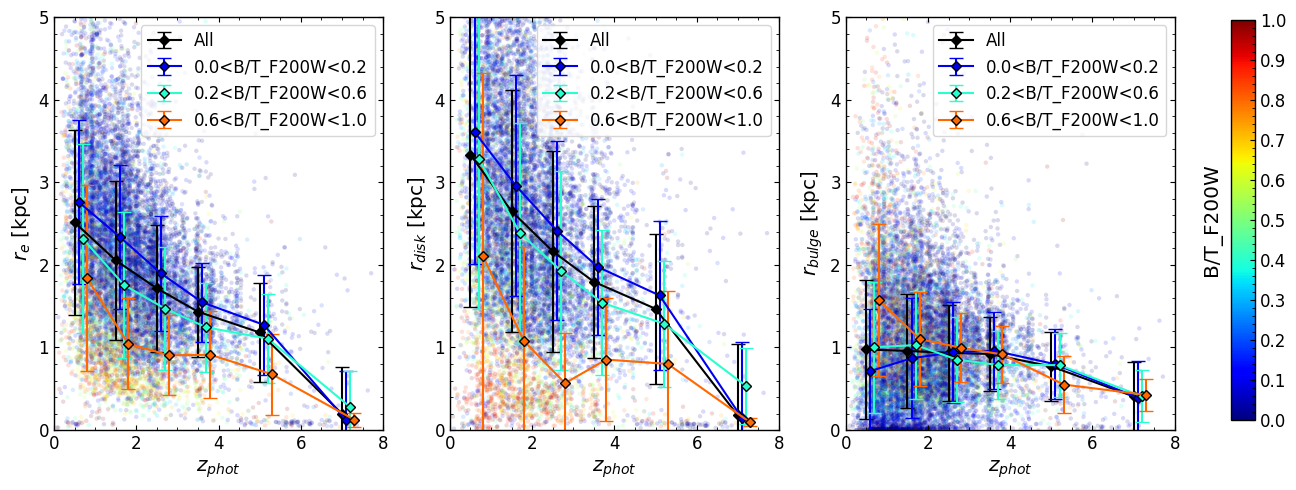

In [17]:
fig, axs = plt.subplots(1,3, figsize=(12,5))

RAD = [good_sersic['RADIUS'], good_BD['DISK_RADIUS_deg'], good_BD['BULGE_RADIUS_deg']]
RAD_NAME = [r"$r_e$ [kpc]", r"$r_{disk}$ [kpc]", r"$r_{bulge}$ [kpc]"]
BT = [(0.0,0.2), (0.2,0.6), (0.6,1.0)]
OFFSETS = [0.1,0.2,0.3]

for j, ax in enumerate(axs):
    radius = (cosmo.kpc_proper_per_arcmin(good_dja['z_phot'])*RAD[j]*u.deg)[cond].to(u.kpc).value
    ax.scatter(z, radius, c=good_BD[cond]['B/T_F200W'], alpha=0.15, s=10, ec='none', vmin=0, vmax=1, cmap='jet')
    scatter_bin(z, radius, z_bins, color='k', ax=ax, label='All', scatter=False)
    for i in range(len(BT)):
        bt = BT[i]
        bt_cond = (good_BD[cond]['B/T_F200W']>bt[0])&(good_BD[cond]['B/T_F200W']<bt[1])
        scatter_bin(z[bt_cond], radius[bt_cond], z_bins, 
                    color=mpl.colormaps.get_cmap('jet')(0.5*(bt[0]+bt[1])), ax=ax, 
                    label=f"{bt[0]:.1f}<B/T_F200W<{bt[1]:.1f}", scatter=False,
                    offset = OFFSETS[i])
    ax.set_xlabel(r"$z_{phot}$")
    ax.set_ylabel(RAD_NAME[j])
    ax.legend()
    ax.set_xlim(z_bins[0], z_bins[-1])
    ax.set_ylim(0,5)

# Ormerod+2023
# z_lin = np.linspace(z_bins[0], z_bins[-1], 100)
# ax.plot(z_lin, 4.5*np.power(1+z_lin, -0.71), ls='--', c='green', label='Ormerod+2023')
# ax.fill_between(z_lin, (4.5+1.32)*np.power(1+z_lin, -0.71+0.19), (4.5-1.32)*np.power(1+z_lin, -0.71-0.19), color='g', alpha=0.2)

cbar_ax = fig.add_axes([1.03, 0.15, 0.02, 0.8])
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('jet'), norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, orientation='vertical', ticks=np.linspace(0,1,11), cax=cbar_ax)
cb.set_label("B/T_F200W", labelpad=-60)

fig.tight_layout()
# fig.savefig(f"{home}/fields/size-evolution_complete.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/size-evolution_complete.png", bbox_inches='tight', dpi=200)
plt.show()

/tmp/ipykernel_11029/2138247324.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


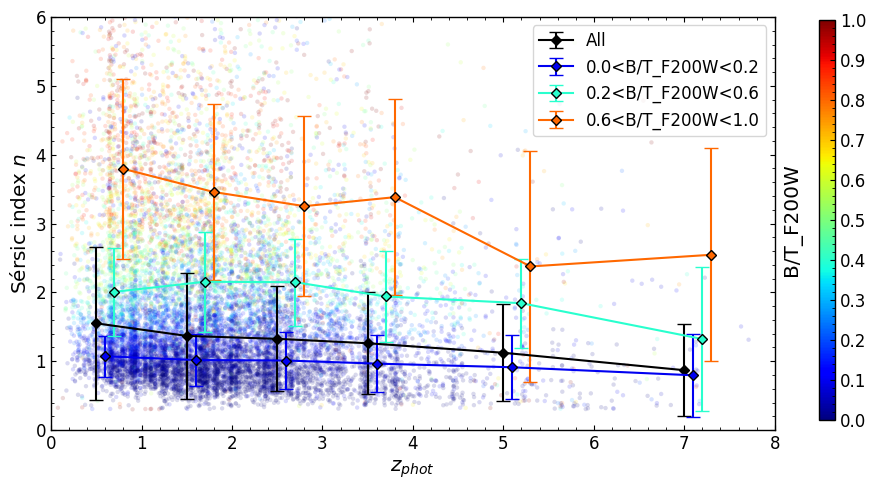

In [21]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

BT = [(0.0,0.2), (0.2,0.6), (0.6,1.0)]
OFFSETS = [0.1,0.2,0.3]

sersic = good_sersic[cond]['SERSIC']
ax.scatter(z, sersic, c=good_BD[cond]['B/T_F200W'], alpha=0.15, s=10, ec='none', vmin=0, vmax=1, cmap='jet')
scatter_bin(z, sersic, z_bins, color='k', ax=ax, label='All', scatter=False)
for i in range(len(BT)):
    bt = BT[i]
    bt_cond = (good_BD[cond]['B/T_F200W']>bt[0])&(good_BD[cond]['B/T_F200W']<bt[1])
    scatter_bin(z[bt_cond], sersic[bt_cond], z_bins, 
                color=mpl.colormaps.get_cmap('jet')(0.5*(bt[0]+bt[1])), ax=ax, 
                label=f"{bt[0]:.1f}<B/T_F200W<{bt[1]:.1f}", scatter=False,
                offset = OFFSETS[i])
ax.set_xlabel(r"$z_{phot}$")
ax.set_ylabel("Sérsic index $n$")
ax.legend()
ax.set_xlim(z_bins[0], z_bins[-1])
ax.set_ylim(0,6)

cbar_ax = fig.add_axes([1.03, 0.15, 0.02, 0.8])
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('jet'), norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, orientation='vertical', ticks=np.linspace(0,1,11), cax=cbar_ax)
cb.set_label("B/T_F200W", labelpad=-60)

fig.tight_layout()
# fig.savefig(f"{home}/fields/sersic-evolution.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/sersic-evolution.png", bbox_inches='tight', dpi=200)
plt.show()

## Quiescent galaxies

In [4]:
snr_cond = (good_sersic['snrratio']>100) & (good_sersic['MAG_MODEL_F277W']<30)
mass_cond = good_dja['mass'] > np.power(10, 10)

sel_dja = good_dja[snr_cond & mass_cond]
sel_sersic = good_sersic[snr_cond & mass_cond]
sel_BD = good_BD[snr_cond & mass_cond]

uv = -2.5*np.log10(sel_dja['restU']/sel_dja['restV'])
vj = -2.5*np.log10(sel_dja['restV']/sel_dja['restJ'])
quiescent = (uv>1.3) & (vj<1.6) & (uv>0.88*vj+0.49)

/tmp/ipykernel_6857/1724508948.py:8: RuntimeWarning: invalid value encountered in log10
  uv = -2.5*np.log10(sel_dja['restU']/sel_dja['restV'])
/tmp/ipykernel_6857/1724508948.py:9: RuntimeWarning: invalid value encountered in log10
  vj = -2.5*np.log10(sel_dja['restV']/sel_dja['restJ'])


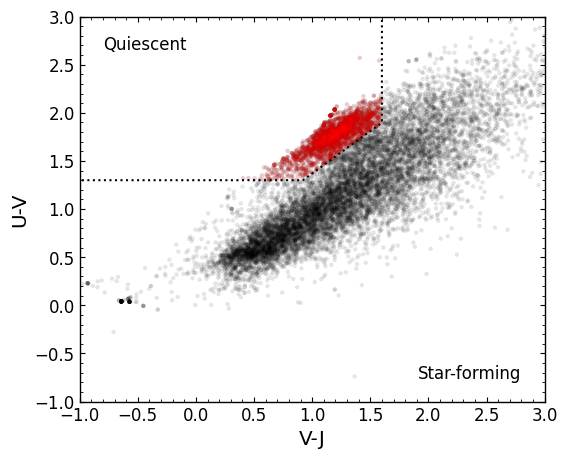

In [5]:
fig, ax = plt.subplots()
ax.scatter(vj, uv, s=10, alpha=0.1, c='k', ec='none')
ax.scatter(vj[quiescent], uv[quiescent], s=10, alpha=0.1, c='r', ec='none')
ax.plot([-2,0.92,1.6,1.6], [1.3,1.3,1.898,4], ls=':', c='k')
ax.set_xlim(-1,3)
ax.set_ylim(-1,3)
ax.set_xlabel("V-J")
ax.set_ylabel("U-V")
ax.text(0.05, 0.95, "Quiescent", transform=ax.transAxes, ha='left', va='top', fontsize='large')
ax.text(0.95, 0.05, "Star-forming", transform=ax.transAxes, ha='right', va='bottom', fontsize='large')
plt.show()

In [6]:
Z = [0,1,2,3,4,5,6]
BT = np.linspace(0, 1, 6)

gal_all, z_edge, bt_edge = np.histogram2d(sel_dja['z_phot'], sel_BD['B/T_F200W'], bins=(Z, BT))
gal_quiescent, _, _ = np.histogram2d(sel_dja['z_phot'], sel_BD['B/T_F200W'], bins=(Z, BT), weights=quiescent)
Z_mesh, BT_mesh = np.meshgrid(z_edge, bt_edge)
frac = gal_quiescent/gal_all
frac[gal_all==0] = np.nan

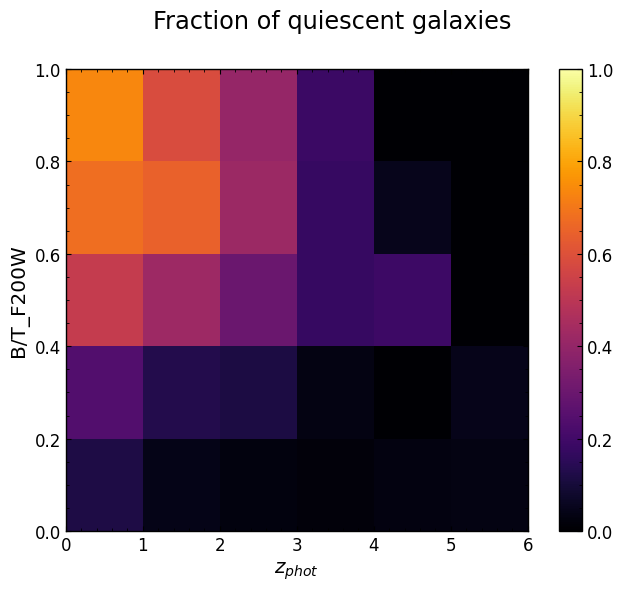

In [7]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

# norm = mpl.colors.LogNorm(vmin=1, vmax=gal_all.max())
# axs[0].pcolormesh(Z_mesh, BT_mesh, gal_all.T, cmap='inferno', norm=norm)

# axs[1].pcolormesh(Z_mesh, BT_mesh, gal_quiescent.T, cmap='inferno', norm=norm)

pcm = ax.pcolormesh(Z_mesh, BT_mesh, frac.T, cmap='inferno', vmin=0, vmax=1)
fig.colorbar(pcm, ax=ax)
ax.set_xlabel("$z_{phot}$")
ax.set_ylabel("B/T_F200W")
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
fig.suptitle("Fraction of quiescent galaxies")

plt.show()

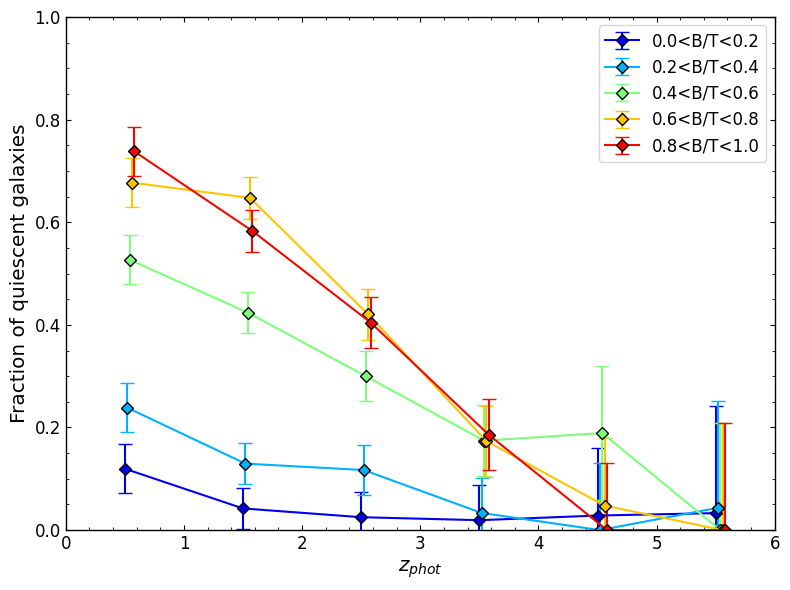

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

z_center = 0.5*(np.roll(Z,-1)+Z)[:-1]
for i in range(len(frac[0])):
    ax.errorbar(z_center+0.02*i, frac[:,i], yerr=1/np.sqrt(gal_all[:,1]), color=mpl.colormaps.get_cmap('jet')(0.5*(BT[i]+BT[i+1])), marker='D', mec='k', label=f'{BT[i]:.1f}<B/T<{BT[i+1]:.1f}')

ax.set_xlabel("$z_{phot}$")
ax.set_ylabel("Fraction of quiescent galaxies")
ax.set_xlim(Z[0],Z[-1])
ax.set_ylim(0, 1)
ax.legend()

fig.tight_layout(rect=(0,0,1,1))
# fig.savefig(f"{home}/fields/fraction-quiescent.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/fraction-quiescent.png", bbox_inches='tight', dpi=200)
plt.show()

In [25]:
gal_sum = np.sum(gal_all, axis=1)
gal_quiescent/np.tile(gal_sum, (len(BT)-1,1)).T

array([[0.0613621 , 0.03506406, 0.07282535, 0.0650708 , 0.07788267],
       [0.02573168, 0.01551758, 0.04655274, 0.05912394, 0.04007071],
       [0.01662936, 0.01535018, 0.02782219, 0.02366485, 0.02302526],
       [0.01241782, 0.00511322, 0.01680058, 0.00949598, 0.00949598],
       [0.01827676, 0.        , 0.01827676, 0.00261097, 0.        ],
       [0.02209945, 0.00552486, 0.        , 0.        , 0.        ]])

In [24]:
print(gal_sum)
print(np.tile(gal_sum, (len(BT)-1,1)).T)

[2966. 5091. 3127. 1369.  383.  181.]
[[2966. 2966. 2966. 2966. 2966.]
 [5091. 5091. 5091. 5091. 5091.]
 [3127. 3127. 3127. 3127. 3127.]
 [1369. 1369. 1369. 1369. 1369.]
 [ 383.  383.  383.  383.  383.]
 [ 181.  181.  181.  181.  181.]]


In [22]:
gal_quiescent

array([[182., 104., 216., 193., 231.],
       [131.,  79., 237., 301., 204.],
       [ 52.,  48.,  87.,  74.,  72.],
       [ 17.,   7.,  23.,  13.,  13.],
       [  7.,   0.,   7.,   1.,   0.],
       [  4.,   1.,   0.,   0.,   0.]])

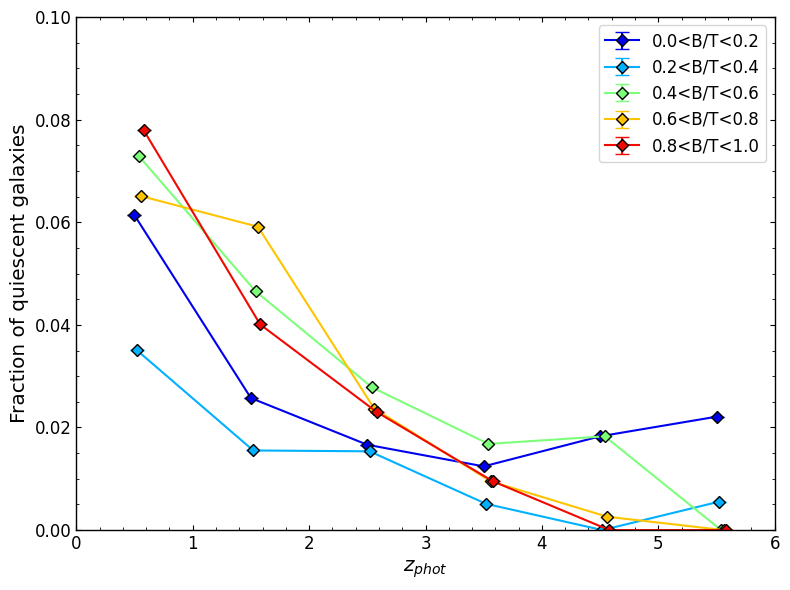

In [37]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

frac_total = gal_quiescent/np.tile(gal_sum, (len(BT)-1,1)).T

z_center = 0.5*(np.roll(Z,-1)+Z)[:-1]
# ax.errorbar(z_center, np.sum(frac_total, axis=1), yerr=0, color='k', marker='D', mec='k', label='All')
for i in range(len(frac[0])):
    ax.errorbar(z_center+0.02*i, frac_total[:,i], yerr=0, color=mpl.colormaps.get_cmap('jet')(0.5*(BT[i]+BT[i+1])), marker='D', mec='k', label=f'{BT[i]:.1f}<B/T<{BT[i+1]:.1f}')

ax.set_xlabel("$z_{phot}$")
ax.set_ylabel("Fraction of quiescent galaxies")
ax.set_xlim(Z[0],Z[-1])
ax.set_ylim(0, 0.1)
ax.legend()

fig.tight_layout(rect=(0,0,1,1))
# fig.savefig(f"{home}/fields/fraction-quiescent.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/fraction-quiescent.png", bbox_inches='tight', dpi=200)
plt.show()

* CEERS : 100 arcmin²
* JADES (GDS+GDN) : 220 arcmin²
* PRIMER UDS : 234 arcmin²
* PRIMER COSMOS : 144 arcmin²

Total survey footprint : 700 arcmin²

In [302]:
angular_vol = 4*np.pi/3 * ((700*u.arcmin**2)/(4*np.pi*u.rad**2)).to(u.one)
co_vol = u.Quantity([angular_vol * (cosmo.comoving_distance(Z[i+1])**3 - cosmo.comoving_distance(Z[i])**3) for i in range(len(Z)-1)])

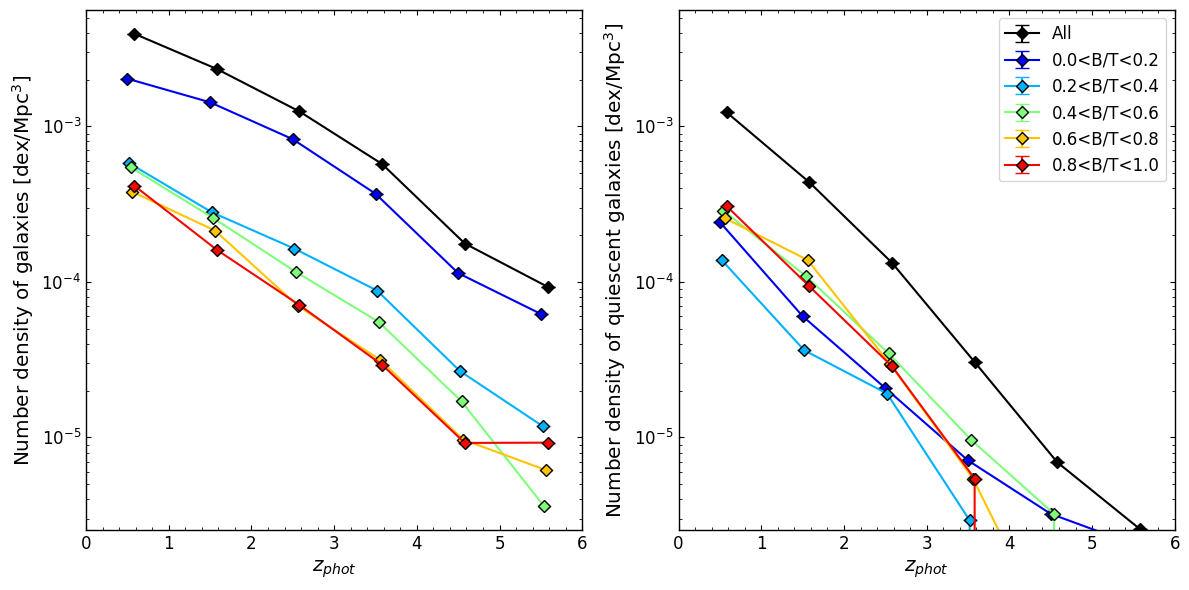

In [318]:
fig, axs = plt.subplots(1,2, figsize=(12,6))

z_center = 0.5*(np.roll(Z,-1)+Z)[:-1]
axs[0].errorbar(z_center+0.02*i, np.sum(gal_all, axis=1)/(co_vol.to(u.Mpc**3)).value, 
                yerr=0, 
                color='k', 
                marker='D', mec='k', label='All')
axs[1].errorbar(z_center+0.02*i, np.sum(gal_quiescent, axis=1)/(co_vol.to(u.Mpc**3)).value, 
                yerr=0, 
                color='k', 
                marker='D', mec='k', label='All')
for i in range(len(frac[0])):
    axs[0].errorbar(z_center+0.02*i, gal_all[:,i]/(co_vol.to(u.Mpc**3)).value, 
                    yerr=0, 
                    color=mpl.colormaps.get_cmap('jet')(0.5*(BT[i]+BT[i+1])), 
                    marker='D', mec='k', label=f'{BT[i]:.1f}<B/T<{BT[i+1]:.1f}')
    axs[1].errorbar(z_center+0.02*i, gal_quiescent[:,i]/(co_vol.to(u.Mpc**3)).value, 
                    yerr=0, 
                    color=mpl.colormaps.get_cmap('jet')(0.5*(BT[i]+BT[i+1])), 
                    marker='D', mec='k', label=f'{BT[i]:.1f}<B/T<{BT[i+1]:.1f}')

axs[0].set_xlabel("$z_{phot}$")
axs[0].set_ylabel("Number density of galaxies [dex/Mpc$^3$]")
axs[0].set_yscale('log')
axs[0].set_xlim(Z[0],Z[-1])

axs[1].set_xlabel("$z_{phot}$")
axs[1].set_ylabel("Number density of quiescent galaxies [dex/Mpc$^3$]")
axs[1].set_yscale('log')
axs[1].set_xlim(Z[0],Z[-1])
axs[1].set_ylim(*axs[0].get_ylim())
axs[1].legend()

fig.tight_layout(rect=(0,0,1,1))
# fig.savefig(f"{home}/fields/fraction-quiescent.pdf", bbox_inches='tight')
# fig.savefig(f"{home}/fields/fraction-quiescent.png", bbox_inches='tight', dpi=200)
plt.show()

In [111]:
def scatter_bin(x, y, x_bins, color, ax, label=None, scatter=True, offset=0, normalize_errors=False):
    x_center = 0.5*(x_bins+np.roll(x_bins, -1))[:-1]
    sigma = np.array([sigma_clipped_stats(y[(x>=x_bins[i])&(x<x_bins[i+1])]) for i in range(len(x_bins)-1)])
    number = np.array([len(y[(x>=x_bins[i])&(x<x_bins[i+1])]) for i in range(len(x_bins)-1)])
    errors = sigma[:,2]/np.sqrt(number) if normalize_errors else sigma[:,2]
    if scatter: ax.scatter(x, y, c=color, s=5, alpha=0.2)
    ax.errorbar(x_center+offset, sigma[:,1], yerr=errors, color=color, mec='k', capsize=5, ms=5, marker='D', label=label)

/tmp/ipykernel_16952/3527032464.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


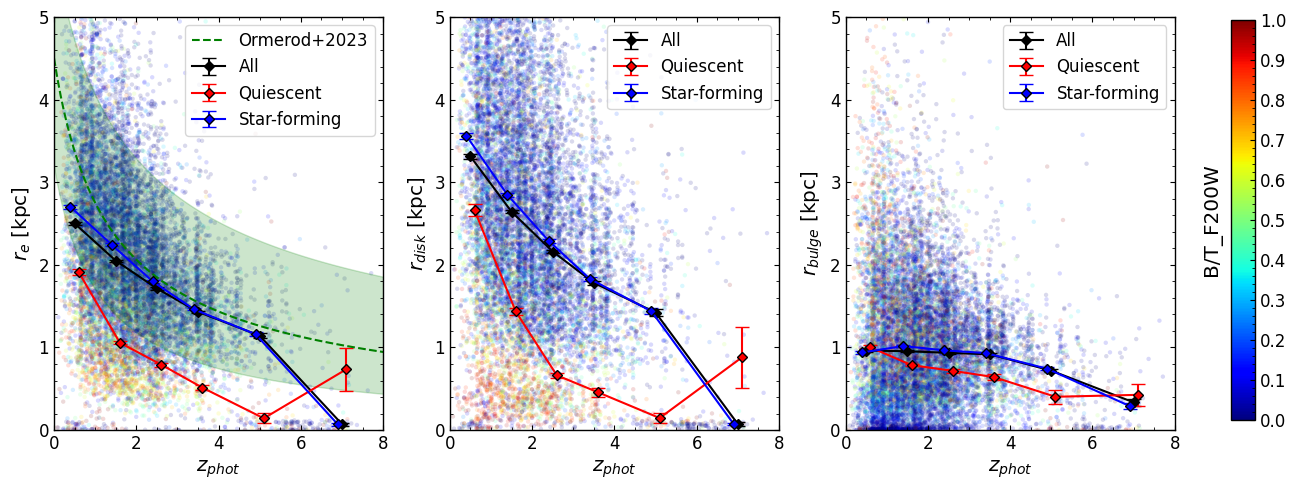

In [122]:
fig, axs = plt.subplots(1,3, figsize=(12,5))

z = sel_dja['z_phot']
z_bins = [0,1,2,3,4,6,8]
RAD = [sel_sersic['RADIUS'], sel_BD['DISK_RADIUS_deg'], sel_BD['BULGE_RADIUS_deg']]
RAD_NAME = [r"$r_e$ [kpc]", r"$r_{disk}$ [kpc]", r"$r_{bulge}$ [kpc]"]

for j, ax in enumerate(axs):
    radius = (cosmo.kpc_proper_per_arcmin(sel_dja['z_phot'])*RAD[j]*u.deg).to(u.kpc).value
    ax.scatter(z, radius, c=sel_BD['B/T_F200W'], alpha=0.15, s=10, ec='none', vmin=0, vmax=1, cmap='jet')
    scatter_bin(z, radius, z_bins, color='k', ax=ax, label='All', scatter=False, normalize_errors=True)
    scatter_bin(z[quiescent], radius[quiescent], z_bins, ax=ax, color='r', label='Quiescent', offset=0.1, scatter=False, normalize_errors=True)
    scatter_bin(z[~quiescent], radius[~quiescent], z_bins, ax=ax, color='b', label='Star-forming', offset=-0.1, scatter=False, normalize_errors=True)
    ax.set_xlabel(r"$z_{phot}$")
    ax.set_ylabel(RAD_NAME[j])
    ax.legend()
    ax.set_xlim(z_bins[0], z_bins[-1])
    ax.set_ylim(0,5)

# Ormerod+2023
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)
axs[0].plot(z_lin, 4.5*np.power(1+z_lin, -0.71), ls='--', c='green', label='Ormerod+2023')
axs[0].fill_between(z_lin, (4.5+1.32)*np.power(1+z_lin, -0.71+0.19), (4.5-1.32)*np.power(1+z_lin, -0.71-0.19), color='g', alpha=0.2)
axs[0].legend()

cbar_ax = fig.add_axes([1.03, 0.15, 0.02, 0.8])
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('jet'), norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, orientation='vertical', ticks=np.linspace(0,1,11), cax=cbar_ax)
cb.set_label("B/T_F200W", labelpad=-60)

fig.tight_layout()
plt.show()

### Image search

#### Download SE++ images

In [5]:
filter = 'f200w'
fields = np.unique(sel_dja['field'])

In [249]:
for field in fields:
    images = dja_sepp.s3.find_files(bucket='aurelien-sepp', 
                                    path=f'{field}/sepp/B+D/checkimages', 
                                    regex=f".+{filter}.+tile-full.+")
    folder = f'{home}/fields/{field}/sepp/B+D/checkimages'
    os.makedirs(folder, exist_ok=True)
    for image in images:
        print(image)
        s3.download_file('aurelien-sepp', f'{field}/sepp/B+D/checkimages/{image}', f"{folder}/{image}")

model_ceers-full-grizli-v7.2-f200w-clear_drc_sci_tile-full_1.fits
resid_ceers-full-grizli-v7.2-f200w-clear_drc_sci_tile-full_1.fits
model_gdn-grizli-v7.3-f200w-clear_drc_sci_tile-full_1.fits
resid_gdn-grizli-v7.3-f200w-clear_drc_sci_tile-full_1.fits
model_gds-grizli-v7.2-f200w-clear_drc_sci_tile-full_1.fits
resid_gds-grizli-v7.2-f200w-clear_drc_sci_tile-full_1.fits
model_primer-cosmos-east-grizli-v7.0-f200w-clear_drc_sci_tile-full_1.fits
resid_primer-cosmos-east-grizli-v7.0-f200w-clear_drc_sci_tile-full_1.fits
model_primer-cosmos-west-grizli-v7.0-f200w-clear_drc_sci_tile-full_1.fits
resid_primer-cosmos-west-grizli-v7.0-f200w-clear_drc_sci_tile-full_1.fits
model_primer-uds-north-grizli-v7.2-f200w-clear_drc_sci_tile-full_1.fits
resid_primer-uds-north-grizli-v7.2-f200w-clear_drc_sci_tile-full_1.fits
model_primer-uds-south-grizli-v7.2-f200w-clear_drc_sci_tile-full_1.fits
resid_primer-uds-south-grizli-v7.2-f200w-clear_drc_sci_tile-full_1.fits


#### Download DJA data images

In [250]:
for field in fields:
    image = dja_sepp.s3.find_files(bucket='grizli-v2', 
                                   path=f'JwstMosaics/v7', 
                                   regex=f"{field}.*{filter}.+sci\.fits\.gz")[0]
    folder = f'{home}/fields/{field}/image'
    os.makedirs(folder, exist_ok=True)
    dja_sepp.s3.decompress_save(image, 'grizli-v2', 'JwstMosaics/v7', folder, verbose=True)

Decompressing : /home/aurelien/DAWN/DJA-SEpp/fields/ceers-full-grizli-v7.2/image/ceers-full-grizli-v7.2-f200w-clear_drc_sci.fits.gz
Removing : /home/aurelien/DAWN/DJA-SEpp/fields/ceers-full-grizli-v7.2/image/ceers-full-grizli-v7.2-f200w-clear_drc_sci.fits.gz
Decompressing : /home/aurelien/DAWN/DJA-SEpp/fields/gdn-grizli-v7.3/image/gdn-grizli-v7.3-f200w-clear_drc_sci.fits.gz
Removing : /home/aurelien/DAWN/DJA-SEpp/fields/gdn-grizli-v7.3/image/gdn-grizli-v7.3-f200w-clear_drc_sci.fits.gz
Decompressing : /home/aurelien/DAWN/DJA-SEpp/fields/gds-grizli-v7.2/image/gds-grizli-v7.2-f200w-clear_drc_sci.fits.gz
Removing : /home/aurelien/DAWN/DJA-SEpp/fields/gds-grizli-v7.2/image/gds-grizli-v7.2-f200w-clear_drc_sci.fits.gz
Decompressing : /home/aurelien/DAWN/DJA-SEpp/fields/primer-cosmos-east-grizli-v7.0/image/primer-cosmos-east-grizli-v7.0-f200w-clear_drc_sci.fits.gz
Removing : /home/aurelien/DAWN/DJA-SEpp/fields/primer-cosmos-east-grizli-v7.0/image/primer-cosmos-east-grizli-v7.0-f200w-clear_drc_

In [24]:
def lookup_source(row, filter='f200w', fit='B+D', size=u.Quantity((5.0,5.0), u.arcsec), 
                  norm='log', legend='', title=None, figsize=(8,6), resid_lim=None):
    field = row['field']
    ra = row['ra']
    dec = row['dec']
    fit_names = {'sersic_rg4':'Sérsic', 'B+D':'B+D'}
    # Open images
    hdu_data = fits.open(glob.glob(f"{home}/fields/{field}/image/*{filter}*sci*.fits")[0], memmap=True)[0]
    hdu_model = fits.open(glob.glob(f"{home}/fields/{field}/sepp/{fit}/checkimages/model*{filter}*tile-full*.fits")[0], memmap=True)[0]
    hdu_resid = fits.open(glob.glob(f"{home}/fields/{field}/sepp/{fit}/checkimages/resid*{filter}*tile-full*.fits")[0], memmap=True)[0]
    # Cutout
    wcs = WCS(hdu_data.header)
    center = SkyCoord(ra, dec, unit='deg', frame='icrs')
    cutout_data  = Cutout2D(hdu_data.data,  position=center, size=size, wcs=wcs, mode='partial', fill_value=0.0)
    cutout_model = Cutout2D(hdu_model.data, position=center, size=size, wcs=wcs, mode='partial', fill_value=0.0)
    cutout_resid = Cutout2D(hdu_resid.data, position=center, size=size, wcs=wcs, mode='partial', fill_value=0.0)
    # Plot
    fig = plt.figure(figsize=figsize)
    #Plots data
    ax = fig.add_subplot(1,3,1, projection=cutout_data.wcs)
    if norm=='log': norm = ImageNormalize(cutout_data.data, interval=MinMaxInterval(), stretch=LogStretch())
    if norm=='zscale': norm = ImageNormalize(cutout_data.data, interval=ZScaleInterval())
    im_data = ax.imshow(cutout_data.data, cmap='gray', origin='lower', norm=norm)
    dja_sepp.utils.add_good_scalebar(ax, cutout_data.wcs)
    ax.set_axis_off()
    ax.set_title(f"Data ({filter.upper()})", size='xx-large')
    cax = fig.add_axes([ax.get_position().x0-0.03,ax.get_position().y0,0.02,ax.get_position().height])
    plt.colorbar(im_data, cax=cax)
    cax.yaxis.set_ticks_position('left')
    # Plots model
    ax_model = fig.add_subplot(1,3,2, projection=cutout_data.wcs)
    ax_model.imshow(cutout_model.data, cmap='gray', origin='lower', norm=norm)
    ax_model.set_axis_off()
    ax_model.set_title(f"Model ({fit_names[fit]})", size='xx-large')
    # Plots residual
    if resid_lim is None: resid_lim = ZScaleInterval().get_limits(cutout_resid.data)
    max_abs = np.max(np.abs(resid_lim))
    ax_resid = fig.add_subplot(1,3,3, projection=cutout_data.wcs)
    im_resid = ax_resid.imshow(cutout_resid.data, cmap='bwr', origin='lower', vmin=-max_abs, vmax=max_abs)
    ax_resid.set_axis_off()
    ax_resid.set_title("Residual", size='xx-large')
    cax = fig.add_axes([ax_resid.get_position().x1+0.01,ax_resid.get_position().y0,0.02,ax_resid.get_position().height])
    plt.colorbar(im_resid, cax=cax)
    if title is None: fig.suptitle(f"{field} #{row['id']}", y=0.77)
    if legend!='': fig.text(0.5,0.33, legend, ha='center', va='top', fontsize='large')
    plt.show()

In [32]:
cond = quiescent & (sel_BD['B/T_F200W']<0.2) & (sel_dja['z_phot']<3) & (sel_dja['z_phot']>2)
sel = np.random.choice(sel_dja[cond], 3)
sel

array([('gdn-grizli-v7.3', 19606, 0.02195972,  869,  814, 11738, 11780, 7286, 7323, 11762.5149339 , 7305.01718686, 15.69474595, 18.33741477, -0.76980629, 1.60941967e-04, 1.49488756e-04, -1.16532870e-06, 4.30642605, 3.93533444, -1.30703366, 0.06384706, 0.05464583, 0.00536061,  3.23412582,  3.24654937, 0.06195661, 0.08976906, 11763, 7305, 11763, 7305, 0, 11763.5149339 , 7306.01718686, 19606, 189.12002792, 62.19446886, 189.12002792, 62.19446886,  3.24593959, 0.00465012,  867, 22.62164892, 2.90546565, 11.9609332 ,  3.07568005, 0.0033787 , 0.00129724, 0,  449.44856938,  0, 1.60933786, 3.10860693,  7.6180363 , 1.17274165, 22.50714124, 0.00119271, 2.09785932, 0.00348959, 0, 0.00018869, 0., 2.54403625, 0.00399352, 0, 0.0003626 , 0.,  2.88593366, 0.00455122, 0, 0.00070401, 0., nan, nan, nan, nan, nan, nan, 0.04426291, 0.00591945, 0.06629574, 0.00821558, 0.08617582, 0.01159421, 0.10506088, 0.00257755, 0.12808395, 0.00352669, 0.14750078, 0.00488437, 0.09832063, 0.00630438, 0.13962722, 0.00870411,

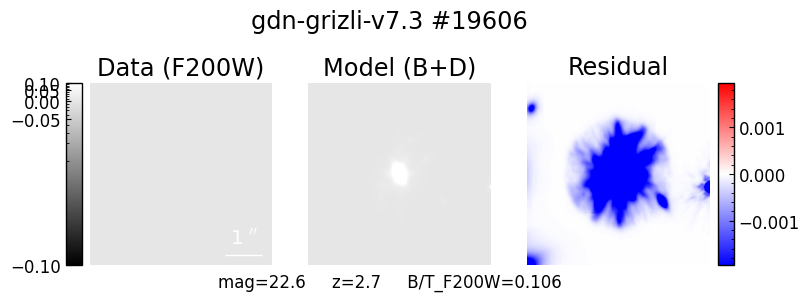

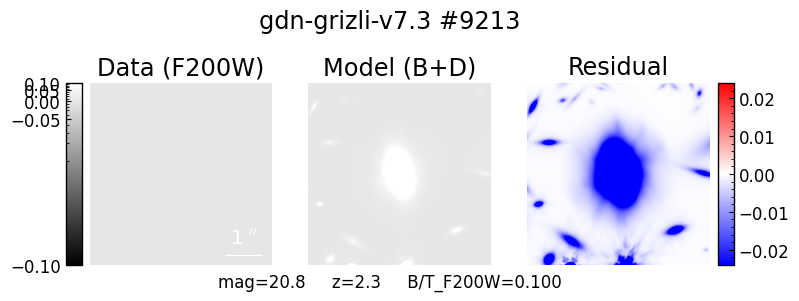

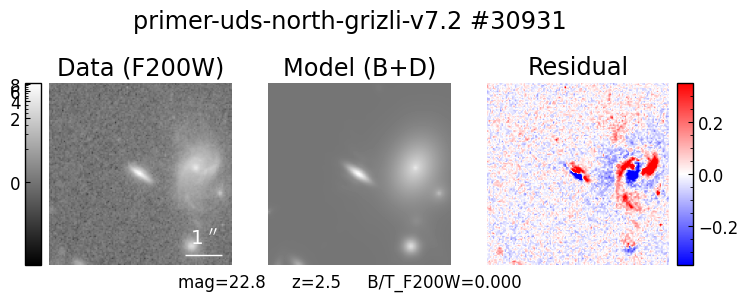

In [33]:
for source in sel:
    index = np.argwhere(sel_dja['id']==source['id'])
    z = source['z_phot']
    bt = sel_BD['B/T_F200W'][index].value[0,0]
    mag = sel_BD[f'MAG_MODEL_{filter.upper()}'][index].value[0,0]
    lookup_source(source, filter=filter, legend=f"mag={mag:.1f}     z={z:.1f}     B/T_F200W={bt:.3f}", norm='log')